In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression

from AnalyzeTools.models import linear_regression, support_vector_regression, random_forest, gradient_boosting, lstm, gru
from AnalyzeTools.prepare import data_split, filterSameColumns, model_eval

c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 경략가격집계 - 소,돼지.csv

In [2]:
''' Read data '''
params_path = '../Parameters'
raw_file_name = '경략가격집계 - 소,돼지'
product = "pork"
product_attribute = "경락가격"

_output = 'MAX_COST_AMT' # MIN_COST_AMT
default_exclude_cols = ['JUDGE_GUBN', 'JUDGE_BREED', 'JUDGE_SEX', 'SABLE_GUBN', 'ABATT_CODE']

df = pd.read_csv('../Data/beef/경략가격집계 - 소,돼지.csv', encoding = 'euc_kr', engine ='python').query("JUDGE_KIND == 2")

In [3]:
data = df.copy()

data = data.drop(default_exclude_cols, axis=1)
data = data.groupby(['STD_DATE']).mean().reset_index()

''' Preprocess data '''
# Delete the column whose correlation to the _output column is NA
features = data.corr()[_output].dropna().index.tolist()
features.remove(_output)

data = data[['STD_DATE'] + features + [_output]]

# Delete the first N rows containing the NA value
drop_rows = []
if data[features].isnull().values.any():
    for i, row in data[features].iterrows():
        if row.isnull().values.any():
            drop_rows.append(i)
            continue
        break

# Fill NA in dataframe
if data[features].isnull().values.any():
    data = data.interpolate(method='linear', limit_direction='forward')

data = data.drop(drop_rows, axis=0)
data.index = range(len(data))

# Parse date
data['STD_DATE'] = data['STD_DATE'].apply(lambda x: "20" + "-".join(x.split("/")))
data['STD_DATE'] = pd.to_datetime(data['STD_DATE'])
data['year'] = data['STD_DATE'].dt.year
data['month'] = data['STD_DATE'].dt.month
data['week'] = data['STD_DATE'].dt.isocalendar().week
data['day'] = data['STD_DATE'].dt.day

data = data[['STD_DATE', 'year', 'month', 'week', 'day'] + features + [_output]] # Organize data

# feature selection
K = int(len(features)/2)
feature_selector = SelectKBest(score_func=f_regression, k=K)
feature_selector.fit_transform(data[features].values, data[_output].values)

# print all features scores
for k, v in zip(features, feature_selector.scores_):
    print(f"{k}: {v}")

k_best_features = list(np.array(features)[feature_selector.get_support()])

# Filter features with almost identical values
_input = filterSameColumns(data, k_best_features + [_output])

data = data[['STD_DATE', 'year', 'month', 'week', 'day'] + _input + [_output]] # Organize data

print("\nInput is: {}\nOutput is: {}".format(_input + [_output], [_output]))


CNT: 10.830940879245123
MIN_COST_AMT: 12225.92215065452
SUM_COST_AMT: 453.80333127638863
SUM_WEIGHT: 22.771022320410545
DEFECT_CNT: 10.847147039897516
DEFECT_MIN_COST_AMT: 12224.429538051429
DEFECT_MAX_COST_AMT: 68115742426.72451
DEFECT_SUM_COST_AMT: 453.74541708319583
DEFECT_SUM_WEIGHT: 22.79391001099421

Input is: ['MIN_COST_AMT', 'SUM_COST_AMT', 'MAX_COST_AMT']
Output is: ['MAX_COST_AMT']


X_train: (2037, 7) y_train: (2037,) X_test: (510, 7) y_test: (510,)

Linear Regression
MAPE: 0.04591060412249452 R square: 0.78870155286058


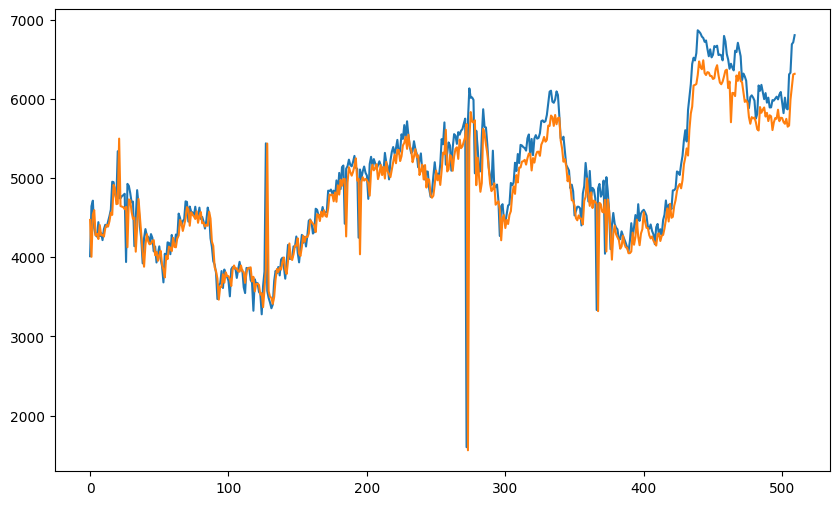


Support Vector Regression
MAPE: 0.13021189283597956 R square: -0.029966896189407732


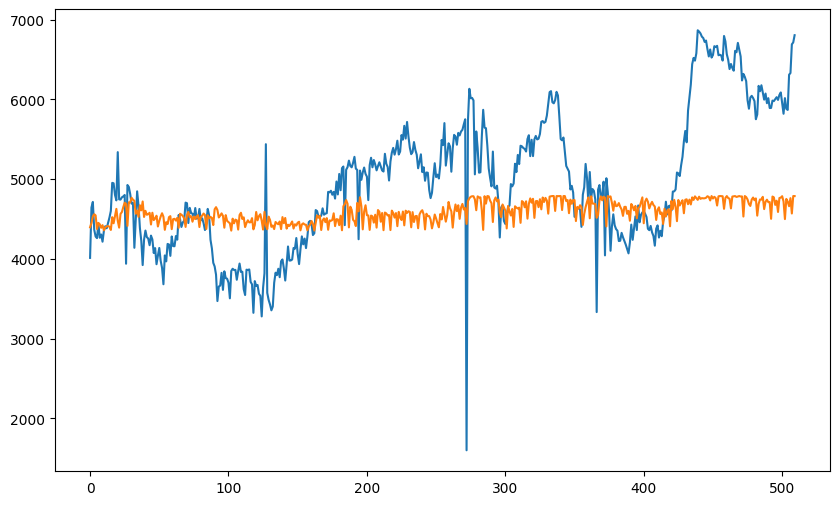


Random Forest
MAPE: 0.053341627870593246 R square: 0.7333485601558969


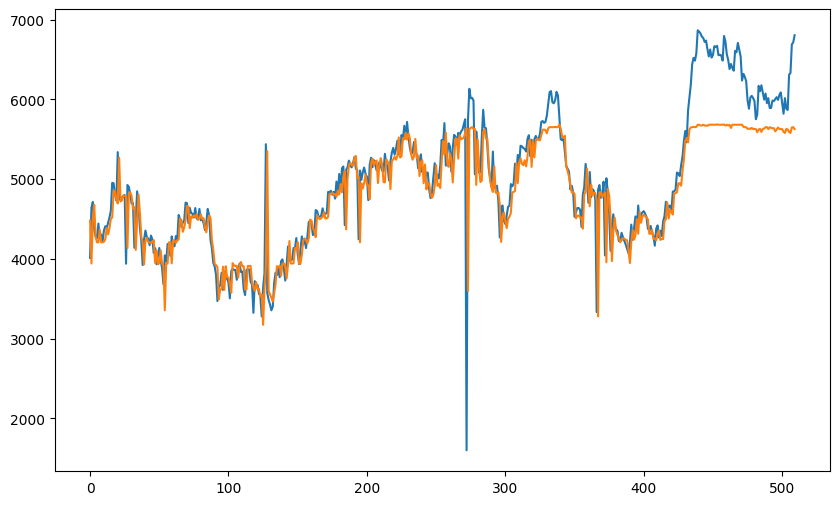


Gradient Boosting
MAPE: 0.05635161126944271 R square: 0.6867822135909332


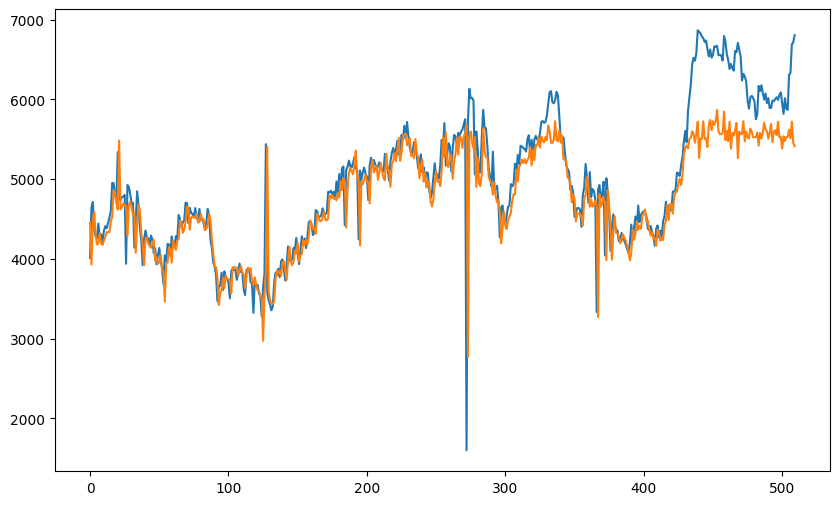

In [8]:
# prepare dataset for ML or DL
ml_split_params = {'Model': 'ML', 'Future': 1}
X_train, X_test, y_train, y_test = data_split(data, input_cols=_input, output=_output, train_size=0.8, **ml_split_params)

''' Input data into models and Evaluate model results '''
ml_searchCV_params = {
    'base_dir': params_path,
    'product': product,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'save': True
}
display = True

print("\nLinear Regression")
lr, _ = linear_regression(X_train, y_train)
model_eval(y_test, lr.predict(X_test), stdout=True, vis=display)

print("\nSupport Vector Regression")
svr, _ = support_vector_regression(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, svr.predict(X_test), stdout=True, vis=display)

print("\nRandom Forest")
rf, _ = random_forest(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, rf.predict(X_test), stdout=True, vis=display)

print("\nGradient Boosting")
gb, _ = gradient_boosting(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, gb.predict(X_test), stdout=True, vis=display)